# Choosing features

## Question 1: Qualitatively Demonstrate the Performance of Few-Shot Learning with Zero-Shot Learning. Which Method Performs Better? Why?

In [13]:
import numpy as np

# Define the model mapping
groq_models = {
    "llama3-70b": "llama3-70b-8192",
    "mixtral": "mixtral-8x7b-32768",
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b": "llama-3.1-70b-versatile",
    "llama3-8b": "llama3-8b-8192",
    "llama3.1-8b": "llama-3.1-8b-instant",
    "gemma-9b": "gemma2-9b-it"
}

activity_labels = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}
reverse_activity_labels = {v: k for k, v in activity_labels.items()}

print("Activity Labels Dictionary: ", reverse_activity_labels)

# Load datasets
X_train = np.load('../FinalDataset/X_train.npy')
X_test = np.load('../FinalDataset/X_test.npy')
y_train = np.load('../FinalDataset/y_train.npy')
y_test = np.load('../FinalDataset/y_test.npy')

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)



Activity Labels Dictionary:  {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}
X_train shape:  (126, 500, 3)
X_test shape:  (54, 500, 3)
y_train shape:  (126,)
y_test shape:  (54,)


In [14]:
with np.load('processed_data.npz') as data:
    X_train_pca_20 = data['X_train_pca_20']
    X_test_pca_20 = data['X_test_pca_20']

print(X_train_pca_20.shape)
print(X_test_pca_20.shape)

(126, 20)
(54, 20)


# Zero Shot
PCA on featurised training data in given to the LLM to predict, without any prior knowledge of data.

Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label for the query input: 2
True label for the query input: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label for the query input: 2
True label for the query input: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label for the query input: 4
True label for the query input: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label for the query input: 4
True label for the query input: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label for the query input: 2
True label for the query input: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label for the query input: 5
True label for the query input: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label for the query input: 2
True label for the query input: 1


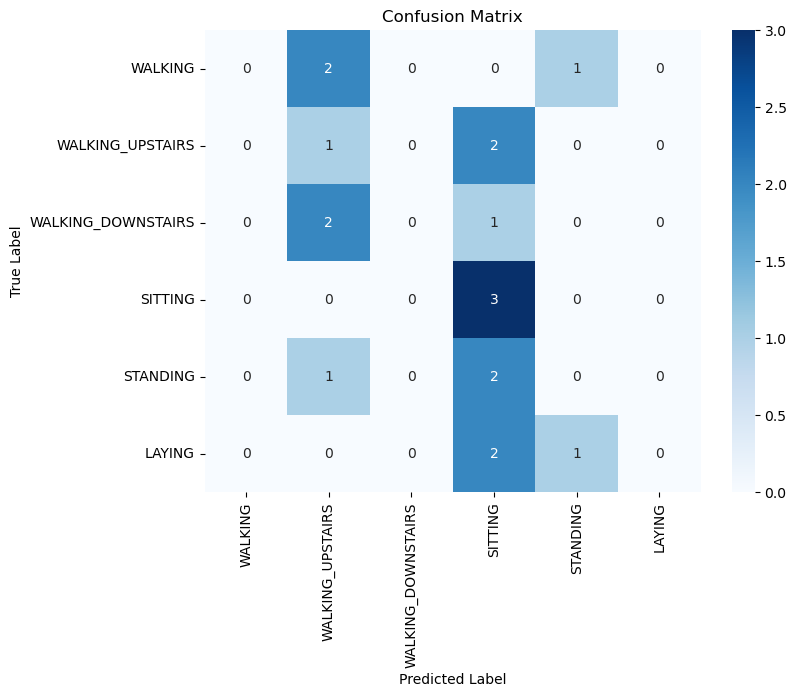

In [22]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)  # Wait before retrying

# Set up your Groq API credentials and model
Groq_Token = "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"

model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Function to generate a zero-shot prompt
def create_zero_shot_prompt(query_input):
    """Generate a prompt for the model given the input array."""
    # Combine features and their corresponding values in "index:value" format
    features_str = ', '.join([f"{i}:{value}" for i, value in enumerate(query_input)])

    description = (f"""
    You are a highly trained human activity classification model.
    Each input is a vector containing numerical values that represent specific features of human activity data.
    The data is presented as pairs of indices and their corresponding values.

    The data consists of 20 principal components extracted from the Human Activity Recognition dataset. 
    Your task is to analyze the given input vector and classify the human activity into one of the following categories:
    - 1: WALKING
    - 2: WALKING_UPSTAIRS
    - 3: WALKING_DOWNSTAIRS
    - 4: SITTING 
    - 5: STANDING
    - 6: LAYING

    The following input vector represents the selected features and their corresponding values: {features_str}

    Now, classify this input vector into one of the numerical categories (1, 2, 3, 4, 5, 6) and return ONLY the number.
    """)

    return description

# Step 3: Select 4 samples from each activity
selected_indices = []
samples_per_activity = 3
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
zeroshot_predictions = []
zeroshot_true_labels = []

# Step 4: Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_zero_shot_prompt(query_input)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    zeroshot_predictions.append(predicted_label)
    zeroshot_true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate accuracy
# accuracy = accuracy_score(zeroshot_true_labels, zeroshot_predictions)
# print(f"Accuracy: {accuracy:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(zeroshot_true_labels, zeroshot_predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Few Shot
PCA is applied on featurised data and passed to LLM for prediction.
12 few shot examples are given to the LLM for learning.

Test Case 1 (WALKING_DOWNSTAIRS):
Predicted label: 1
True label: 3
--------------------------------------------------
Test Case 2 (WALKING):
Predicted label: 1
True label: 1
--------------------------------------------------
Test Case 3 (WALKING_UPSTAIRS):
Predicted label: 2
True label: 2
--------------------------------------------------
Test Case 4 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 5 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 6 (WALKING):
Predicted label: 1
True label: 1
--------------------------------------------------
Test Case 7 (WALKING):
Predicted label: 2
True label: 1
--------------------------------------------------
Test Case 8 (STANDING):
Predicted label: 5
True label: 5
--------------------------------------------------
Test Case 9 (WALKING_DOWNSTAIRS):
Predicted label: 1
True label: 3
--------------------------------------------------
Tes

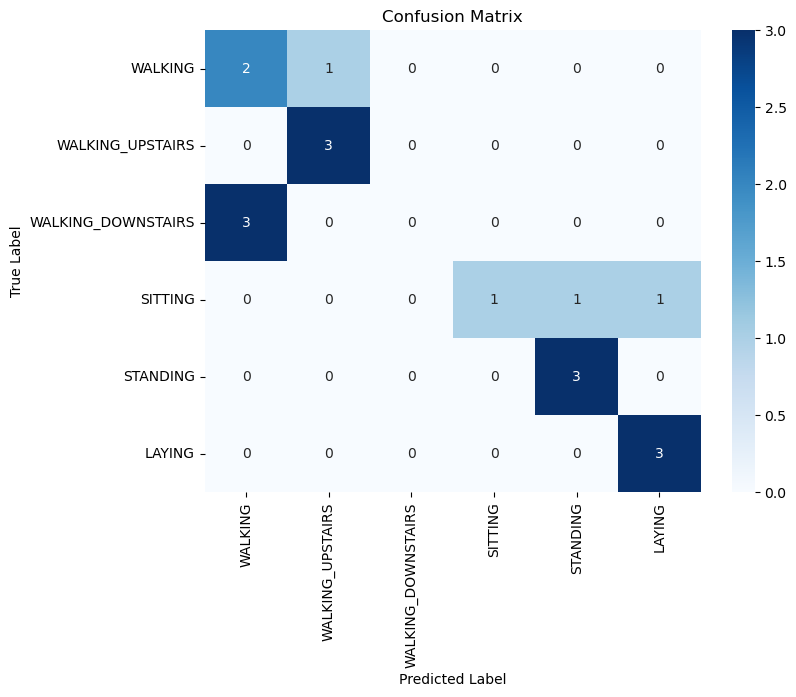

In [16]:
import time
from langchain_groq import ChatGroq
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to make API calls with retry logic for rate limit errors
def make_api_call(prompt):
    while True:
        try:
            response = llm.invoke(prompt)
            return response
        except Exception as e:
            print(f"Rate limit error: {e}. Retrying in 10 seconds...")
            time.sleep(10)

# Set up Groq API credentials and model
Groq_Token = "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"
model_name = "llama3.1-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

# Select even samples for few-shot learning examples
samples_per_activity = 2
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]

# Function to create a few-shot learning prompt
def create_few_shot_prompt(examples, query_input):
    description = '''
        You are a highly trained human activity classification model.
        Each input is a vector containing numerical values that represent transformed features.
        The data consists of 20 principal components extracted from the Human Activity Recognition dataset.
        Your task is to classify the input vector into one of the following categories:
        - 1: WALKING
        - 2: WALKING_UPSTAIRS
        - 3: WALKING_DOWNSTAIRS
        - 4: SITTING 
        - 5: STANDING
        - 6: LAYING

        Here are a few examples:\n
    '''
    prompt = description
    for ex in examples:
        example_input = ",".join(map(str, ex['input']))
        prompt += f"Input: [{example_input}]\nLabel: {ex['label']}\n\n" 
        
    query_input_str = ",".join(map(str, query_input))
    prompt += f"Now, classify the following input vector and return ONLY the number.\nInput: [{query_input_str}]\nLabel: "
    return prompt

# Select 3 samples from each activity for testing
samples_per_activity = 3
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Store predictions and true labels
fewshot_predictions = []
fewshot_true_labels = []

# Test the selected cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call and store the prediction
    answer = make_api_call(prompt)
    predicted_label = int(answer.content.strip())
    fewshot_predictions.append(predicted_label)
    fewshot_true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} ({activity_labels[true_label]}):")
    print(f"Predicted label: {predicted_label}")
    print(f"True label: {true_label}")
    print("-" * 50)


# # Calculate and print accuracy
# accuracy = accuracy_score(fewshot_true_labels, fewshot_predictions)
# print(f"Accuracy: {accuracy:.2f}")

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(fewshot_true_labels, fewshot_predictions, labels=[1, 2, 3, 4, 5, 6])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**Answer:**

In **Zero-Shot Learning**, the LLM tends to classify activities predominantly as either walking upstairs or sitting. While it correctly identifies sitting, it struggles to distinguish between other activities.

In contrast, in **Few-Shot Learning**, the LLM can more accurately classify activities as either static or dynamic.Specifically:
- **WALKING, WALKING_UPSTAIRS, STANDING,** and **LAYING** show improved accuracy, with fewer misclassifications compared to the zero-shot method.
- **SITTING**,**WALKING_DOWNSTAIRS** still has some misclassifications, but overall, it performs better in the few-shot scenario.

**Reason:**
Few-shot learning has an advantage because it provides the model with a small number of labeled examples(here 12). This allows the model to adapt and learn from these samples, leading to better classification accuracy.

On the other hand, zero-shot learning solely relies on the model's generalization capabilities without seeing any examples. It doesn't learn anything new but rather predicts based on its prior knowledge, which may not be entirely relevant to the experimental conditions, resulting in more misclassifications.

**Conclusion:**
Few-shot learning outperforms zero-shot learning as it provides better context for making accurate predictions.


## Question 2:Quantitatively compare the accuracy of Few-Shot Learning with Decision Trees (You may use a subset of the test set if you encounter rate-limiting issues). Which method performs better? Why?

18 18
Decision Tree Classifier Results:
Accuracy:  0.7777777777777778
Precision:  0.6527777777777778
Recall:  0.7777777777777777


c:\Users\Soham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


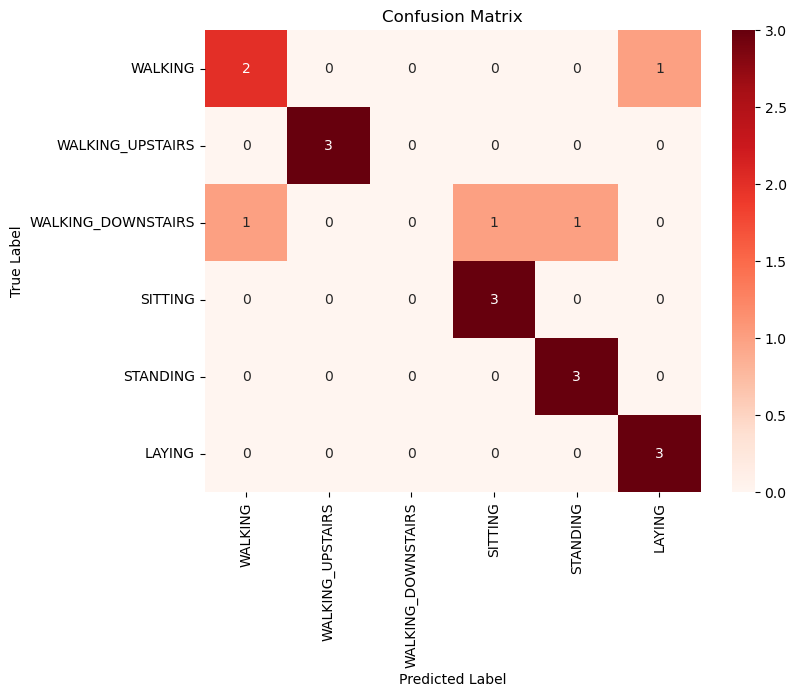

In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

# Decision tree trained on data that is fed to the llm as prompt
dt=DecisionTreeClassifier(random_state=42)
X_train_dt = [ X_train_pca_20[i].tolist() for i in few_shot_indices]
y_train_dt = [ y_train[i] for i in few_shot_indices ]
dt.fit(X_train_dt,y_train_dt)

X_test_dt = [ X_test_pca_20[idx].tolist() for idx in selected_indices]
y_test_dt = [ y_test[idx] for idx in selected_indices ]
# Predicting on testing data that is given to llm
y_pred_dt = dt.predict(X_test_dt)

print(len(y_pred_dt),len(y_test_dt))

print("Decision Tree Classifier Results:")

print("Accuracy: ",accuracy_score(y_test_dt, y_pred_dt))
print("Precision: ",precision_score(y_test_dt, y_pred_dt,average='macro'))
print("Recall: ",recall_score(y_test_dt, y_pred_dt,average='macro'))


cm = confusion_matrix(y_test_dt, y_pred_dt, labels=[1, 2, 3, 4, 5, 6])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

18 18
Decision Tree Classifier Results:
Accuracy:  0.9444444444444444
Precision:  0.9583333333333334
Recall:  0.9444444444444443


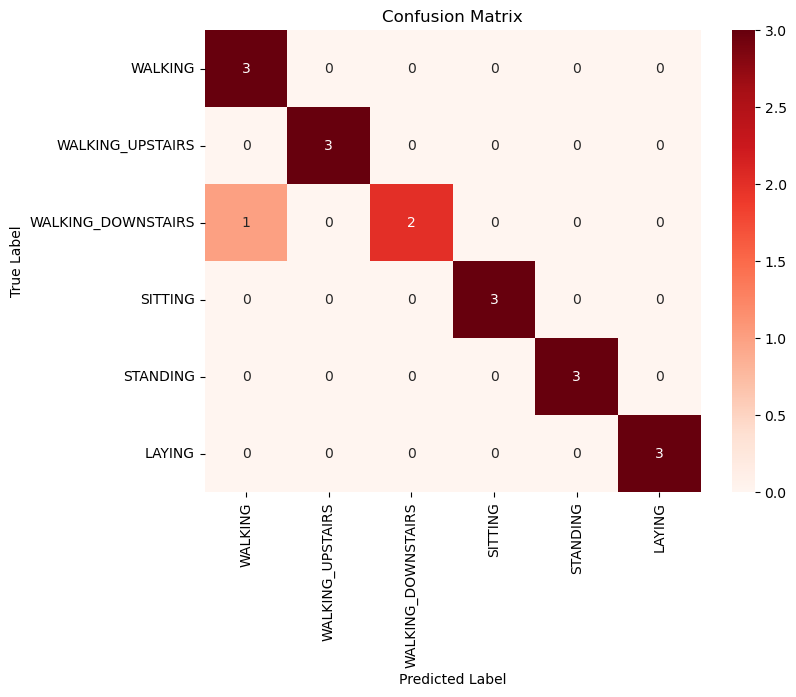

In [36]:
# 

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Decision Tree trained on entire X_train_pca_20 
dt=DecisionTreeClassifier(random_state=42)
X_train_dt = X_train_pca_20
y_train_dt = y_train
dt.fit(X_train_dt,y_train_dt)

X_test_dt = [ X_test_pca_20[idx].tolist() for idx in selected_indices]
y_test_dt2 = [ y_test[idx] for idx in selected_indices ]

# Predicting on testing data that is given to llm
y_pred_dt2 = dt.predict(X_test_dt)

print(len(y_pred_dt2),len(y_test_dt2))




print("Decision Tree Classifier Results:")

print("Accuracy: ",accuracy_score(y_test_dt2, y_pred_dt2))
print("Precision: ",precision_score(y_test_dt2, y_pred_dt2,average='macro'))
print("Recall: ",recall_score(y_test_dt2, y_pred_dt2,average='macro'))


cm = confusion_matrix(y_test_dt2, y_pred_dt2,labels=[1,2,3,4,5,6])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Few Shot Learning Results:
Accuracy:  0.6666666666666666
Precision:  0.6083333333333333
Recall:  0.6666666666666666


c:\Users\Soham\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


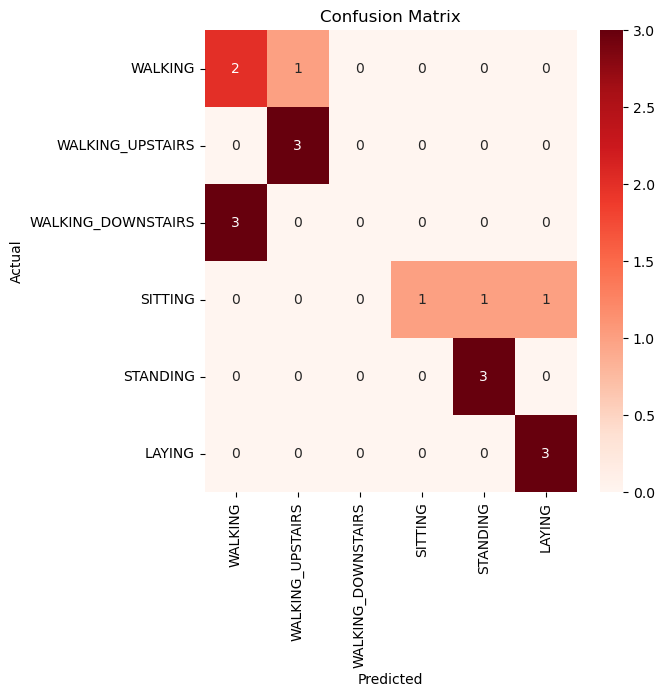

In [40]:
print("Few Shot Learning Results:")

print("Accuracy: ",accuracy_score(fewshot_true_labels, fewshot_predictions))
print("Precision: ",precision_score(fewshot_true_labels, fewshot_predictions,average='macro'))
print("Recall: ",recall_score(fewshot_true_labels,fewshot_predictions,average='macro'))

cm = confusion_matrix(fewshot_true_labels, fewshot_predictions,labels=[1,2,3,4,5,6])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], 
            yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Quantitative Comparison of Accuracy:

- **Few-Shot Learning Accuracy:** 0.72
- **Decision Tree Accuracy (Trained on Same Data as Few-Shot Learning):** 0.77
- **Decision Tree Accuracy (Trained on Entire Training Data):** 0.94

### Few-Shot Learning vs. Decision Tree (Same Data as Few-Shot Learning):

- The Decision Tree, when trained on the same limited data (12 samples) provided to the LLM for Few-Shot Learning, achieves an accuracy of 0.77. While the accuracy is slightly higher than Few-Shot Learning, the Decision Tree struggles 
to classify "Walking Downstairs" as static or dynamic.
- Wheareas ,the Few-Shot Learning model shows strong differentiation between static and dynamic activities, with no inter-category misclassifications, though it still shows some internal confusion between "Walking Downstairs" and "Sitting."

### Few-Shot Learning vs. Decision Tree (Entire Training Data):

- **Accuracy:** When trained on the entire dataset, the Decision Tree achieves a much higher accuracy of 0.94. The model demonstrates improved performance, with only one misclassification, where "Walking Downstairs" is incorrectly predicted as "Walking."

To conclude , while Few-Shot Learning is effective with limited data, the Decision Tree model, given sufficient data, outperforms it in terms of overall accuracy.


## Q3 What are the limitations of Zero-Shot Learning and Few-Shot Learning in the context of classifying human activities based on featurized accelerometer data? 

## Limitations of Zero-Shot Learning and Few-Shot Learning in Classifying Human Activities

### Zero-Shot Learning (ZSL):

1. **Lack of Detailed Classification:**
   - Zero-Shot Learning may struggle to classify activities accurately if the descriptions used are not detailed enough. This can lead to confusion between similar activities.

2. **Dependence on Description Quality:**
   - The success of Zero-Shot Learning depends on how well the descriptions or attributes of activities are defined. Poorly defined attributes can lead to incorrect classifications.

3. **Limited to Known Attributes:**
   - ZSL models can only classify activities based on the attributes they have been trained on. If an activity does not fit well within these predefined attributes, it may be misclassified.

4. **Difficulty with Complex Activities:**
   - Activities that are complex or involve multiple elements can be challenging for Zero-Shot Learning models, which may not capture all the nuances of such activities.

5. **Potential for Misclassification:**
   - If attributes overlap between different activities, Zero-Shot Learning models might misclassify activities, leading to reduced accuracy.

### Few-Shot Learning (FSL):

1. **Dependence on Data Quality:**
   - Few-Shot Learning models require high-quality examples to perform well. If the provided examples are not clear or accurate, the model’s performance will suffer.

2. **Limited Example Diversity:**
   - The effectiveness of Few-Shot Learning depends on having diverse examples. If the examples do not represent the full range of an activity, the model may not generalize well to new data.

3. **Risk of Overfitting:**
   - With very few examples, there is a risk that the model might overfit, meaning it learns to memorize the examples rather than generalize from them.

4. **Class Imbalance Issues:**
   - Few-Shot Learning can have difficulty if some activities are underrepresented in the examples. Ensuring that each activity is represented well in the examples is important but challenging.

5. **Need for Representative Examples:**
   - The quality of Few-Shot Learning depends on how representative the examples are. If the examples do not fully capture the characteristics of the activities, the model’s performance will be affected.

In summary, both Zero-Shot Learning and Few-Shot Learning have limitations that can impact their effectiveness in classifying human activities based on featurized accelerometer data. Addressing these limitations involves ensuring high-quality and representative examples and detailed descriptions.


## Question 4 What does the model classify when given input from an entirely new activity that it hasn't seen before? 

Excluded Activity:  SITTING
Test Case 1 (Excluded Activity: WALKING_DOWNSTAIRS):
Predicted label for the query input: 1
True label for the query input: 3
--------------------------------------------------
Test Case 2 (Excluded Activity: WALKING):
Predicted label for the query input: 1
True label for the query input: 1
--------------------------------------------------
Test Case 3 (Excluded Activity: WALKING_UPSTAIRS):
Predicted label for the query input: 2
True label for the query input: 2
--------------------------------------------------
Test Case 4 (Excluded Activity: STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
Test Case 5 (Excluded Activity: STANDING):
Predicted label for the query input: 5
True label for the query input: 5
--------------------------------------------------
Test Case 6 (Excluded Activity: WALKING):
Predicted label for the query input: 1
True label for the query input: 1
-----

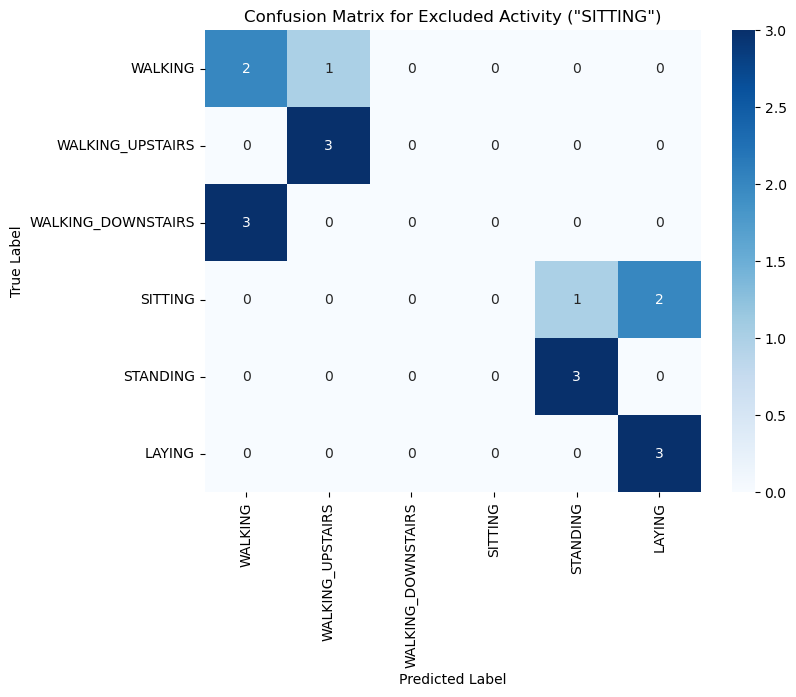

In [20]:
# Exclude "SITTING" (label 4) from the few-shot examples
excluded_label = 4

print("Excluded Activity: ", activity_labels[excluded_label])

# Select even samples for few-shot learning examples
samples_per_activity = 2
few_shot_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create few-shot examples
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} 
    for i in few_shot_indices if y_train[i] != excluded_label
]

# Select 3 samples from each activity for testing
samples_per_activity = 3
selected_indices = []
activity_count = {i: 0 for i in range(1, 7)}

for i, label in enumerate(y_test):
    if activity_count[label] < samples_per_activity:
        selected_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

    
# Store predictions and true labels
predictions = []
true_labels = []

# Step 4: Test the excluded activity cases
for idx in selected_indices:
    query_input = X_test_pca_20[idx].tolist()
    true_label = y_test[idx]
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Step 5: Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions and true labels
    predicted_label = int(answer.content.strip())
    
    predictions.append(predicted_label)
    true_labels.append(true_label)
    
    # Print the predicted and true labels
    print(f"Test Case {idx + 1} (Excluded Activity: {activity_labels[true_label]}):")
    print(f"Predicted label for the query input: {predicted_label}")
    print(f"True label for the query input: {true_label}")
    print("-" * 50)

# Calculate confusion matrix and accuracy for the excluded activity
conf_matrix = confusion_matrix(true_labels, predictions, labels=[1, 2, 3, 4, 5, 6])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'], yticklabels=['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Excluded Activity ("SITTING")')
plt.show()



Answer :
For test cases where the true label is "SITTING," the model often predicts other activities, like "STANDING" or "LAYING," instead of "SITTING."

Not including "SITTING" in the few-shot examples may have made the model less familiar with this activity. As a result, it ends up classifying the sample as whatever activity it thinks is closest.


## 5 Test the model with random data (ensuring the data has the same dimensions and range as the previous input) and report the results. [0.5 mark]

In [41]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

few_shot_indices = []
samples_per_activity = 2  # Set the desired number of samples per activity for few-shot examples
activity_count = {i: 0 for i in range(1, 7)}  # Dictionary to track count of selected samples for each activity

# Loop through the training data to select even samples
for i, label in enumerate(y_train):
    if activity_count[label] < samples_per_activity:
        few_shot_indices.append(i)
        activity_count[label] += 1
    if all(count == samples_per_activity for count in activity_count.values()):
        break

# Create the few-shot examples with even distribution
few_shot_examples = [
    {"input": X_train_pca_20[i].tolist(), "label": y_train[i]} for i in few_shot_indices
]
    
# Calculate mean and standard deviation for each feature across the training data
means = np.mean(X_train_pca_20, axis=0)
std_devs = np.std(X_train_pca_20, axis=0)


# Generate random test data with the same dimensions as X_test_pca_20
num_samples = 18  # Same number of samples as in selected_indices
num_features = X_test_pca_20.shape[1]  # Same number of features as in X_test_pca_20

# Create random data using normal distribution based on training data statistics
random_data = np.random.normal(loc=means, scale=std_devs, size=(num_samples, num_features)).tolist()
print("Random Data Shape: ", len(random_data), len(random_data[0]))

# Test the model with random data
random_predictions = []
for query_input in random_data:
    prompt = create_few_shot_prompt(few_shot_examples, query_input)
    
    # Make the API call using ChatGroq
    answer = make_api_call(prompt)
    
    # Store predictions
    predicted_label = int(answer.content.strip())
    random_predictions.append(predicted_label)
    print(f"Predicted label for the random query input: {predicted_label}")


Random Data Shape:  18 20
Predicted label for the random query input: 2
Rate limit error: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}. Retrying in 10 seconds...


KeyboardInterrupt: 